#### Technical preamble
If you want to run the code in this notebook from scratch, start by installing everything necessary to locally run an IPython notebook (see [the IPython website](http://ipython.org/notebook.html) for advice on how to do this). Then, install `seaborn`:  

    pip install seaborn  
    
and `emcee`:  

    pip install emcee
    
`pip` should be able to track down any dependencies that need installing or updating.

In [1]:
%matplotlib inline
from __future__ import division
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn
seaborn.set_style('ticks')
seaborn.set_context('talk', font_scale=1.75)
pt_kwrgs = {'linestyle':'None', 'color':'black', 'capsize':0, 'markersize':10, 'marker':'o', 'zorder':4}
emph_line_kwrgs = {'color':'red', 'zorder':3}
plain_line_kwrgs = {'color':'black', 'zorder':2}
realization_kwrgs = {'color':'gray', 'linewidth':1.5, 'zorder':1, 'alpha':0.3}
empirical_cdf_kwrgs = {'color':'black', 'histtype':'step', 'cumulative':-1, 'normed':True, 'linewidth':2}

# Part 0: A few terms
For the sake of clarity, we're going to briefly define *likelihoods*, *priors*, and *posteriors*.

First, we'll need to define conditional probability.
$$
    p(X \vert Y)
$$
means "the probability of $X$ happening if $Y$ has happened" and is called the conditional probability of $X$ given $Y$.

Now, suppose we have a statistical model. This model has some parameters, which we will call $\theta$, and some observables, which we will call $y$. If we set the parameters $\theta$ to fixed values, we can define a *likelihood function*,
$$
    p(y \vert \theta).
$$
An observation can be thought of as a draw from a likelihood function. 

We can also define a probability distribution for the model parameters $\theta$:
$$
    p(\theta \vert y) = \frac{p(y \vert \theta) p(\theta)}{\int p(y \vert \theta) p(\theta) \, {\rm d} \theta}.
$$
The probability distribution $p(\theta \vert y)$ is called the *posterior probability distribution*. The posterior probability distribution combines the likelihood function $p(y \vert \theta)$ with the *prior probability distribution* $p(\theta)$. The likelihood function uses $y$ to inform $\theta$. The prior is information about $\theta$ that we had before measuring $y$. The term in the denominator is a normalization factor.

# Part I: What is model criticism and when is it useful?

This treatment of model criticism is based on Gelman, Meng, and Stern, 1996, **Posterior predictive assessment of model fitness via realized discrepancies **, which can be found [here](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf).

Sometimes, you have two statistical models for a dataset. You fit both, compare the two, and pick the better one.

This type of procedure involves *model comparison*. Picking how many objects there are in a scene, how many transiting objects are necessary to explain a light curve, or whether or not to include an extra intrinsic scatter term in a model can all be done using model comparison. 

All of these decisions are based on assessments of relative model quality -- which of these two models does better? Evaluating how well a model reproduces some observations, whether or not it is a "good fit", is variously called *hypothesis testing*, *model criticism*, and many others names. We are going to use the name *model criticism*. 

We're going to talk about three ways of doing model criticism -- visually comparing models to data, visually comparing  likelihoods to data, and different kinds of $p$-values.

## A quick spherical cow

Plotting your best-fit model with your observations is pretty much always a good idea. Plotting your best fit model with your observations doesn't necessarily have a clear interpretation in terms of likelihood functions or posterior probability distributions, but is often useful anyway.

In this example, we're fitting points along a line through the origin with a line through the origin.

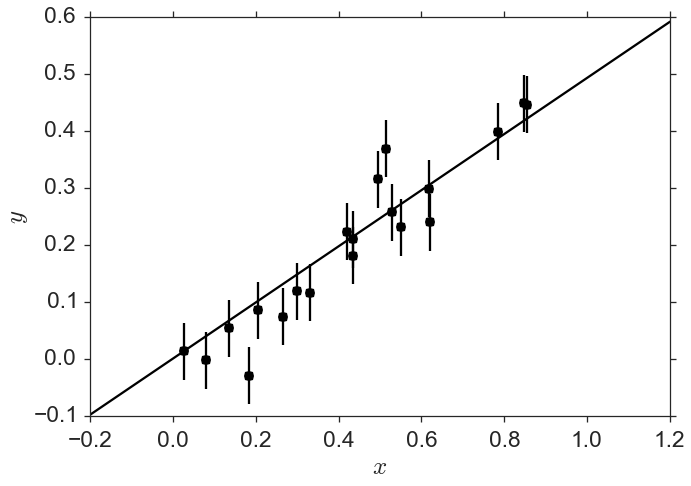

In [2]:
rng = np.random.RandomState(seed=2)
N_points = 20
slope = 0.5

obs_sigma = 0.05

x = rng.uniform(0, 1, size=N_points)
obs = x * slope + rng.normal(0, obs_sigma, size=N_points)

solution = np.linalg.lstsq(x.reshape([-1, 1]), obs)
recovered_slope = solution[0]
x_axis = np.linspace(-0.2, 1.2, 2)

plt.errorbar(x, obs, yerr=obs_sigma, **pt_kwrgs)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_axis, recovered_slope * x_axis, **plain_line_kwrgs);

Not unexpectedly, the model goes through the observations. A reasonable fraction ($\approx 1/3$) of the observations are more than $1\, \sigma$ away from model.

If we also care about what the uncertainty on the model parameters looks like, we can plot model realizations. Plotting model realizations lets us visually compare draws from the posterior probability distribution with obserations.

We're going to use `emcee`, the popular Markov chain Monte Carlo (MCMC) program, to generate these realizations. While MCMC is absolutely overkill for this problem, it's easy to implement and quick to run.

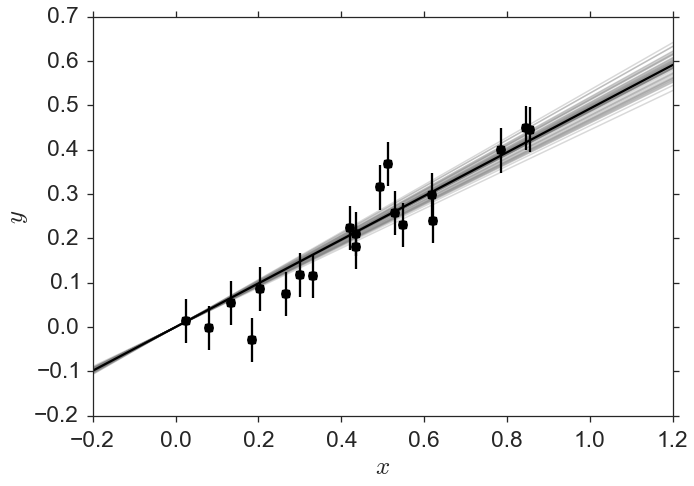

In [3]:
N_walkers = 10
N_dim = 1
args = [x, obs, obs_sigma]
N_burn = 200
N_iter = 200
N_realizations = 50

def model(slope, x):
    return slope * x

def log_likelihood(slope, x, obs, obs_sigma):
    lnp = -0.5 *np.sum((model(slope, x) - obs)**2) / obs_sigma**2
    return lnp
    
initial_state = np.random.normal(0, 1, size=[N_walkers, N_dim])
sampler = emcee.EnsembleSampler(N_walkers, N_dim, log_likelihood, args=args)
initial_state, _, _ = sampler.run_mcmc(initial_state, N_burn, storechain=False)
sampler.run_mcmc(initial_state, N_iter)

realizations = np.zeros([2, N_realizations])
realization_indices = np.random.choice(N_iter * N_walkers, replace=True, size=N_realizations)

for realization_number, index in enumerate(realization_indices):
    realizations[:, realization_number] = model(sampler.flatchain[index], x_axis)

plt.errorbar(x, obs, yerr=obs_sigma, **pt_kwrgs)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_axis, recovered_slope * x_axis, **plain_line_kwrgs)
plt.plot(x_axis, realizations, **realization_kwrgs);

## A less artificial example
This example is uses data from and is based on Chiaberge et al., 2015, **Radio Loud AGNs are Mergers**, which can be found [here](http://arxiv.org/abs/1505.07419).

Let's say we have two samples. We've measured whether or not some property applies to each object. 

For example, let's suppose our first sample is 19 radio-loud Type 2 AGN and our second sample is 35 radio-quiet Type 2 AGN. We've checked to see if the host galaxies of these AGN are mergers. In the radio-loud sample, 18 of the 19 host galaxies are mergers while in the radio-quiet sample, 13 of the 35 host galaxies are mergers.

We want to figure out how likely it is that the distribution of mergers in these two samples is the same. Put another way, we want to know how often a model in which radio-loud and radio-quiet AGN hosts have the same merger probability would produce these two samples.

The model for the equal merger probability hypothesis is:
$$
\begin{align}
    p_{m} &\sim \text{A reasonable prior} \\
    N_{RL, m} &\sim \text{Binomial} (N_{RL},\, p_m)\\
    N_{RQ, m} &\sim \text{Binomial} (N_{RQ},\, p_m)
\end{align}
$$

The notation $x \sim Y$ means "$x$ is generated from the probability distribution $Y$." For the sake of simplicity, we're going to assume a uniform prior between 0 and 1 for $p_{m}$. 

To get the best-fit $p_m$, which we will call $\hat{p}_m$, we just treat the two samples as one bigger sample:
$$
    \hat{p}_m = \frac{N_{RL, m} + N_{RQ, m}}{N_{RQ} + N_{RL}}.
$$

There are several ways to "plot the model", in this case. To lose as little information as possible, we will plot the location of the samples in binomial distributions with the appropriate sample size and a common $\hat{p}_m$.

In [4]:
N_RL = 19
N_RQ = 35
N_RL_m = 18
N_RQ_m = 13
p_m_hat = (N_RL_m + N_RQ_m) / (N_RL + N_RQ)

def plot_binomial_case(N_total, N_m_obs, p_m):
    N_m_axis = np.arange(0, N_total + 1, 1)
    p_N_m = stats.binom.pmf(N_m_axis, N_total, p_m)
    plt.errorbar(N_m_axis, p_N_m, **pt_kwrgs)
    plt.axvline(N_m_obs, **emph_line_kwrgs)
    plt.xlabel('$N_m$')
    plt.ylabel('$P(N_m)$');

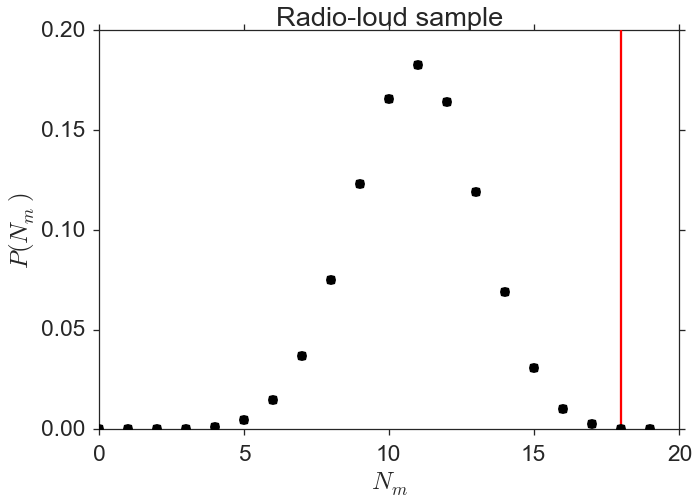

In [5]:
plot_binomial_case(N_RL, N_RL_m, p_m_hat)
plt.title('Radio-loud sample');

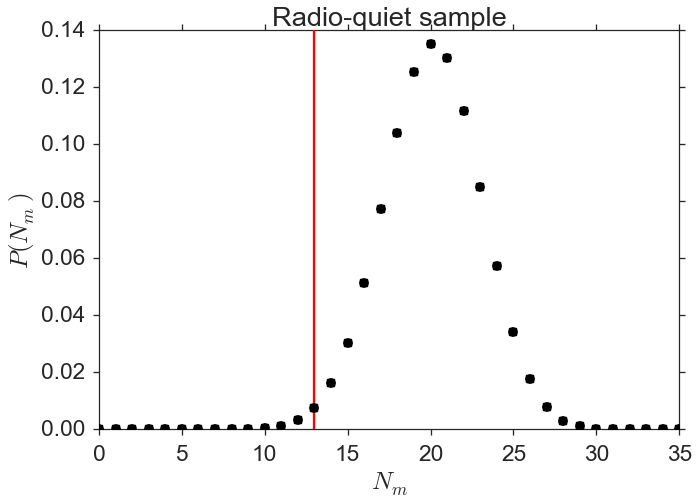

In [6]:
plot_binomial_case(N_RQ, N_RQ_m, p_m_hat)
plt.title('Radio-quiet sample');

The dots are the likelihood functions for the number of mergers in each sample. The red vertical lines are the observed numbers of mergers.

The combined-sample best fit merger probability doesn't agree with either sample. Both observed values are far into the low-probability areas of the individual samples' probability distributions. The observations are sufficiently unlikely that for some people, these two plots would be enough justification to reject the model, or get people to start arguing about the finer points of sample selection.

In some cases, we (or people we are beholden to) want to summarize this qualitative impression with a number. Perhaps things look a bit closer than in this case, or maybe there are $10^4$ pairs of samples and we don't have time to look through that many plots. The number we are looking for is called a predictive $p$-value. 

## Discrepancies and sampling distributions

A $p$-value summarizes how likely it is for a model to generate an observation *at least as extreme* as the actual observation. 

First, we need to put all possible observations in some sort of order. This is usually done by defining a function that maps things in the observable space to scalars and ordering the space of the scalars in a reasonable way. For example, we could map observations, which are pairs of integers, to their sums, which are individual integers, and use the everyday way of ordering integers.

Depending on the form of the observation-to-scalar function and who you ask, this function can be called a *test statistic*, *discrepancy functional*, or something else entirely.

*Test statistics* can be anything, but are often expected to be independent of model parameters.
If $y$ is an observation, $\theta$ and $\theta'$ are parameter sets, and $f$ is a test statistic, then
$$
    f(y, \theta) = f(y, \theta').
$$

*Discrepancy functionals* are allowed to depend to model parameters and are expected, though not always required, to be larger for more unusual observations. We will use *test statistic* when we mean something that we expect to be independent of model parameters and *discrepancy functional* when we mean something that we expect to increase for more unusual observations. We're mostly going to be talking about discrepancy functionals.

For our example, we'll use the $\chi^2$ discrepancy functional:
$$
    \chi^2 = \sum_{\text{samples}} \frac{(\text{observed} - \text{expected})^2}{\text{expected}}.
$$

The expected value of a binomial variable with total $N$ and probability $p$ is just $Np$, so the data's $\chi^2$ discrepancy is:

In [7]:
def compute_chi_squared_discrepancy(N_sample_1, N_sample_1_m, N_sample_2, N_sample_2_m, p_m):
    chi_squared = (N_sample_1_m - (N_sample_1 * p_m_hat))**2 / (N_sample_1 * p_m) 
    chi_squared += (N_sample_2_m - (N_sample_2 * p_m_hat))**2 / (N_RQ * p_m)
    return chi_squared

chi_squared_obs = compute_chi_squared_discrepancy(N_RL, N_RL_m, N_RQ, N_RQ_m, p_m_hat)
print chi_squared_obs

7.11564394858


Next, we need to figure out how unusual the observed discrepancy functional is. One of the more intuitive ways to do this is to repeatedly generate artificial data from the model, compute its discrepancy functional, and use this collection of discrepancy functional values to estimate the discrepancy functional's survival distribution function. (The survival distribution function is like the cumulative distribution function, but in the opposite direction.)

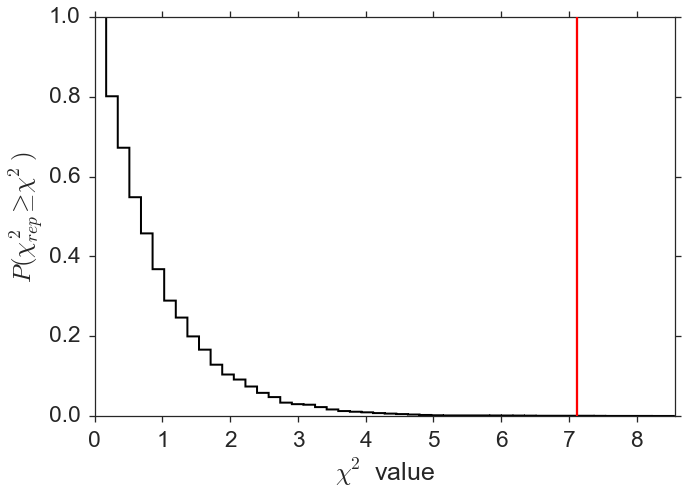

In [8]:
N_draws = 10000

np.random.seed(5)
N_RL_m_draws = stats.binom.rvs(N_RL, p_m_hat, size=N_draws)
N_RQ_m_draws = stats.binom.rvs(N_RQ, p_m_hat, size=N_draws)
chi_squared_draws = compute_chi_squared_discrepancy(N_RL, N_RL_m_draws, N_RQ, N_RQ_m_draws, p_m_hat)

hist_max = max(chi_squared_draws.max(), chi_squared_obs) * 1.05
plt.hist(chi_squared_draws, bins=50, range=[0, hist_max], **empirical_cdf_kwrgs)
plt.xlim(0, hist_max)
plt.axvline(chi_squared_obs, **emph_line_kwrgs)
plt.xlabel('$\chi^2$ value')
plt.ylabel('$P(\chi^2_{rep} \geq \chi^2)$');

The $p$-value is the probability that $\chi^2_{rep} \geq \chi^2_{obs}$:

In [9]:
p_chi_squared_obs = np.count_nonzero(chi_squared_draws >= chi_squared_obs) / N_draws
print p_chi_squared_obs

0.0005


That's our quantitative answer -- if there is a single $p_m$, the probability of generating the two observed samples is about 0.0005.

## Three valid questions

1. The answer we got is approximate. If you change the argument of `np.random.seed`, you'll get a slightly different value.

2. Why did we pick this specific discrepancy functional? What would happen if we picked a different one?

3. Our model has been pinned at the best-fit value. What if $p_m$ is uncertain?

Let's go through these one at a time.

#### 1. This $p$-value is approximate. Should we be worried?

Yes, it is and no, in this case you probably shouldn't be. For variables that take on a finite number of discrete values, we can compute the $p$-value exactly by a brute-force calculation. We won't do this here, since the brute-force approach doesn't generalize well to continuous values, but our approximate $p$-value is not that far off from the truth. Specifically, it is always extremely low, so while the actual value may change, the interpretation remains the same.

In general, $p$-values are almost always approximate in one way or another. If we aren't using approximate numerics, we've probably made simplifying assumptions about the distributions involved in the problem. For example, if we assume that binomial distributions can be reasonably approximated as normal distributions, we can come up with a different $p$-value for the above problem that can be computed using the CDF of the normal distribution.

#### 2. What would happen if we picked a different discrepancy functional?

We would get a different answer. A $p$-value tells you something about the combination of a statistical model and an observation-to-scalar function. Change the function, change the $p$-value.

Let's use the negative log-likelihood as the discrepancy functional instead of the chi-squared value.

In [10]:
def negative_lnp(N_sample_1, N_sample_1_m, N_sample_2, N_sample_2_m, p_m):
    lnp = stats.binom.logpmf(N_sample_1_m, N_sample_1, p_m)
    lnp += stats.binom.logpmf(N_sample_2_m, N_sample_2, p_m)
    return -lnp

neg_lnp_obs = negative_lnp(N_RL, N_RL_m, N_RQ, N_RQ_m, p_m_hat)
print neg_lnp_obs

12.7778988312


0.0001


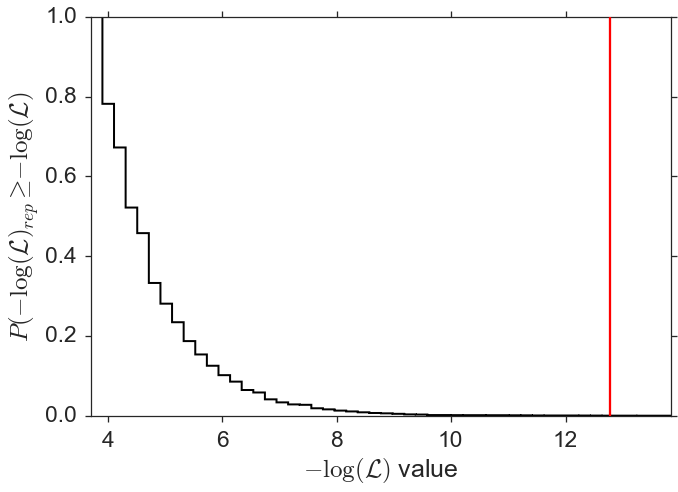

In [11]:
neg_lnp_draws = negative_lnp(N_RL, N_RL_m_draws, N_RQ, N_RQ_m_draws, p_m_hat)

hist_min = neg_lnp_draws.min()
hist_max = max(neg_lnp_draws.max(), neg_lnp_obs) * 1.05
plt.hist(neg_lnp_draws, bins=50, range=[hist_min, hist_max], **empirical_cdf_kwrgs)
plt.xlim(hist_min, hist_max)
plt.axvline(neg_lnp_obs, **emph_line_kwrgs)
plt.xlabel('$-\log(\mathcal{L})$ value')
plt.ylabel('$P(-\log(\mathcal{L})_{rep} \geq -\log(\mathcal{L})$')
p_neg_lnp = np.count_nonzero(neg_lnp_draws >= neg_lnp_obs) / N_draws
print p_neg_lnp

With the same set of draws as the first discrepancy functional (which gave a $p$-value of 0.0005), this discrepancy functional gives a $p$-value of 0.0001. As in point on approximate $p$-values, this does not change the actual decision that we make based on this $p$-value. 

### 3. How do we include uncertainties in $p_m$?
Instead of generating observations from the model likelihood at fixed $p_m$, we generate observations from the model posterior. As before, we generate $p_m$ values using MCMC.

In [12]:
N_walkers = 10
N_dim = 1
args = [N_RL, N_RL_m, N_RQ, N_RQ_m]
N_burn = 200
N_iter = 1000

def log_posterior(p_m, N_sample_1, N_sample_1_m, N_sample_2, N_sample_2_m):
    if (p_m < 0) or (p_m > 1):
        return -np.Infinity
    else:
        lnp = stats.binom.logpmf(N_sample_1_m, N_sample_1, p_m)
        lnp += stats.binom.logpmf(N_sample_2_m, N_sample_2, p_m)
        return lnp

initial_state = rng.uniform(0, 1, size=[N_walkers, N_dim])
sampler = emcee.EnsembleSampler(N_walkers, N_dim, log_posterior, args=args)
initial_state, _, _ = sampler.run_mcmc(initial_state, N_burn, storechain=False, rstate0=rng)
sampler.run_mcmc(initial_state, N_iter)

p_m_draws = sampler.flatchain[:,0]
N_RL_m_draws = stats.binom.rvs(N_RL, p_m_draws)
N_RQ_m_draws = stats.binom.rvs(N_RQ, p_m_draws)
realization_discrepancy = compute_chi_squared_discrepancy(N_RL, N_RL_m_draws, N_RQ, N_RQ_m_draws, p_m_draws)
obs_discrepancy = compute_chi_squared_discrepancy(N_RL, N_RL_m, N_RQ, N_RQ_m, p_m_draws)

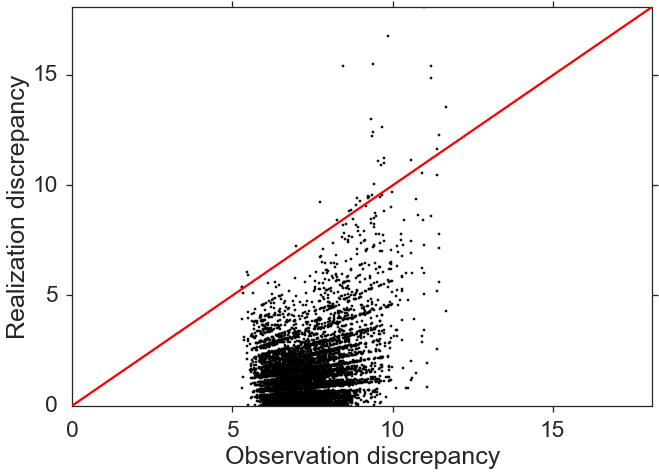

In [13]:
plt.scatter(obs_discrepancy, realization_discrepancy, color='black', s=5)
xmin = min(obs_discrepancy.min(), realization_discrepancy.min())
xmax = max(obs_discrepancy.max(), realization_discrepancy.max())
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.plot([xmin, xmax], [xmin, xmax], scalex=False, scaley=False, **emph_line_kwrgs)
plt.xlabel('Observation discrepancy')
plt.ylabel('Realization discrepancy');

The "at-least as extreme points" are the ones that fall above the red line, so the $p$-value is approximately the fraction of points above the red line.

In [14]:
print np.count_nonzero(realization_discrepancy > obs_discrepancy) / obs_discrepancy.size

0.0035


This $p$-value is higher than the previous two, but is still small enough to generally feel confident about rejecting the equal $p_m$ hypothesis.

## Quick recap

1. Use different kinds of model visualization to judge how well models fit data.
2. Use $p$-values to quantify how well models fit data, both with and without model parameter uncertainty.
3. Different ways of computing $p$-values give different answers.
4. If you do use $p$-values, evaluate model fit by eye as well.